<a href="https://colab.research.google.com/github/Damian25-lamn/aprendizaje-automatico-252601/blob/main/Minda_Damian_4_8_M%C3%A9todo_de_clustering_espectral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 **Taller 4.8: Taller de Método de Clustering Espectral**


## OBJETIVOS DEL TALLER:
En esta práctica vamos a poner en práctica los conceptos vistos en clase relacionados con los métodos de clustering espectral.

# 🔧 **CONFIGURACIÓN INICIAL**

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix, diags, eye, issparse
from scipy import linalg

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [54]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

Cargamos el dataset reducido, para probar este algoritmo

✅ Dataset cargado desde URL GitHub


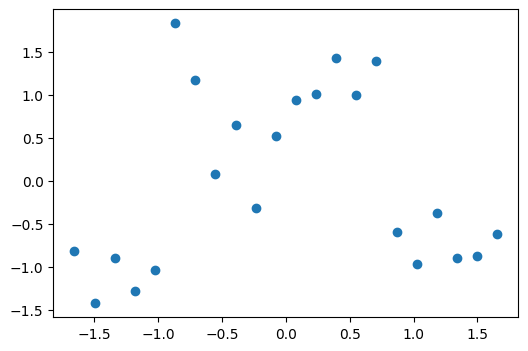

In [55]:
D =cargar_dataset("dataset_reducido.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False),:]
Dx = D[:,:2]

from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
Dx = scaler.fit_transform(Dx)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1])

# 🎯 **1:Cree el Algoritmo de Clustering Espectral**

## PASO 1: GRAFO DE SIMILITUD


### Metodo para Graficar un Grafo de Similitud


In [56]:
def plt_grafo_afinidad(Dx, A):
    # Verificar si hay conexiones
    # Normalizar pesos para grosor
    non_zero_mask = A > 0
    non_zero_vals = A[non_zero_mask]

    min_val = np.min(non_zero_vals)
    max_val = np.max(non_zero_vals)

    # Evitar división por cero
    if max_val - min_val == 0:
        aux = np.ones_like(non_zero_vals) * 0.5
    else:
        aux = (non_zero_vals - min_val) / (max_val - min_val)

    # Grosor entre 0.5 y 5
    W_scaled = 0.5 + 4.5 * aux

    # Crear matriz de grosores
    W = np.zeros_like(A, dtype=float)
    W[non_zero_mask] = W_scaled

    # Crear figura
    fig, ax = plt.subplots(figsize=(6, 4))

    # Puntos
    ax.scatter(Dx[:, 0], Dx[:, 1], s=80, c='blue', alpha=0.7)
    for i in range(Dx.shape[0]):
        ax.annotate(str(i),
                   xy=(Dx[i, 0], Dx[i, 1]),  # ¡IMPORTANTE: tupla (x, y)!
                   xytext=(3, 3),
                   textcoords='offset points')
    inds = np.where(A > 0)
    for i in range(len(inds[0])):
        idx1 = inds[0][i]
        idx2 = inds[1][i]
        # Solo graficar una vez por par (i < j)
        if idx1 < idx2:
            ax.plot([Dx[idx1, 0], Dx[idx2, 0]],
                   [Dx[idx1, 1], Dx[idx2, 1]],
                   linestyle='-',
                   linewidth=W[idx1, idx2],
                   c='red',
                   alpha=0.5)
    ax.set_title(f'Grafo de Afinidad ({len(inds[0])//2} conexiones)')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### a)	El grafo ε-vecindad

In [57]:
def grafo_epsilon(Dx, epsilon, sigma=None):
    #sigma: si es None, grafo binario; si es float, pesos gaussianos
    n = Dx.shape[0]
    distancias = euclidean_distances(Dx)
    # Máscara binaria: 1 si distancia < epsilon
    mascara = (distancias < epsilon).astype(float) # p1 tu codigo aqui
    np.fill_diagonal(mascara, 0)  # eliminar self-loops, No queremos que un nodo cercano de si mismo
    if sigma is None:
        # Grafo binario
        W = mascara
    else:
        # Grafo con pesos gaussianos dentro de epsilon
        W = np.exp(-distancias**2 / (2 * sigma**2))
        W = W * mascara # p2 tu codigo aqui
        np.fill_diagonal(W, 0)
    return W

#### Selección de ε (epsilon) y σ (sigma) en la Construcción del Grafo
1. Para ε (epsilon) - Radio de Vecindad

In [58]:
distancias = euclidean_distances(Dx)
n = distancias.shape[0]
distancias_vals = distancias[np.triu_indices(n, k=1)]
epsilon = np.median(distancias_vals)

print(f"Método: Mediana")
print(f"  Epsilon sugerido: {epsilon:.4f}")
print(f"  Proporción de conexiones: {np.mean(distancias_vals <= epsilon):.2%}")

Método: Mediana
  Epsilon sugerido: 1.9545
  Proporción de conexiones: 50.22%


2. Para σ (sigma) - Ancho del Kernel Gaussiano

In [59]:
mascara = distancias < epsilon
distancias_filtradas = distancias[mascara]
sigma = np.median(distancias_filtradas[distancias_filtradas > 0])
print(f"Sigma sugerido: {sigma:.4f}")

Sigma sugerido: 1.1317


In [60]:
W = grafo_epsilon(Dx, epsilon, sigma)   # p3 tu codigo aqui

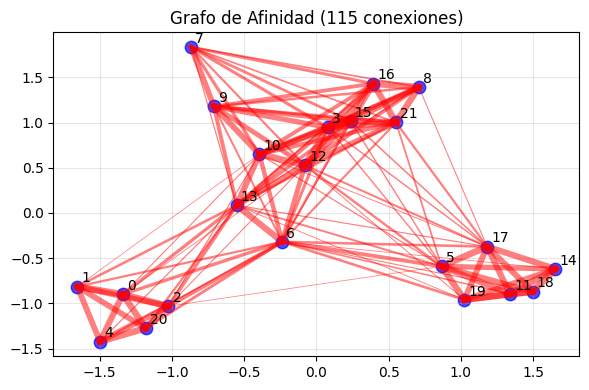

In [61]:
plt_grafo_afinidad(Dx, W)

### b)	El grafo k-Vecinos Más Cercanos (k-NN)

In [62]:
def grafo_knn(Dx, knn, sigma=None, modo='interseccion'):
    n = Dx.shape[0]
    distancias = euclidean_distances(Dx)
    W_dir = np.zeros((n, n))
    # Construir grafo dirigido de k-NN
    for i in range(n):
        # Índices de los k vecinos más cercanos (excluyendo i)
        indices = np.argsort(distancias[i])[1:knn+1]
        if sigma is None:  # Binario
            W_dir[i, indices] = 1
        else: # Gaussiano
            for j in indices:
                d = distancias[i, j]
                W_dir[i, j] = np.exp(-d**2 / (2 * sigma**2))
    # Aplicar modo de simetría
    if modo == 'dirigido':
        W = W_dir
    elif modo == 'union': # Unión: i-j conectados si i→j O j→i
        W = np.maximum(W_dir, W_dir.T)
    elif modo == 'interseccion': # i-j conectados solo si i→j Y j→i
        W = W_dir * W_dir.T
    elif modo == 'mutuo':  # verifica explícitamente vecindad mutua
        W = np.zeros((n, n))
        for i in range(n):
            vecinos_i = np.where(W_dir[i] > 0)[0]
            for j in vecinos_i:
                if W_dir[j, i] > 0:  # j también tiene a i como vecino
                    W[i, j] = W_dir[i, j]
        W = np.maximum(W, W.T)  # hacer simétrico
    np.fill_diagonal(W, 0)# Eliminar self-loops
    return W

#### 1. Para k (número de vecinos)

##### a) Regla logarítmica (para datos bien comportados):

In [63]:
n = Dx.shape[0]
k_base = int(np.log2(n)) + 1  # Mínimo razonable
k_max = int(np.sqrt(n))       # Máximo razonable
k_recomendado = min(max(k_base, 5), k_max)  # Entre 5 y sqrt(n)
print(f"k recomendado: {k_recomendado}")

k recomendado: 4


##### b) Basado en la dimensionalidad intrínseca:

In [64]:
def estimar_k_por_dimensionalidad(Dx, muestra=1000):
    if len(Dx) > muestra:
        indices = np.random.choice(len(Dx), muestra, replace=False)
        muestra_datos = Dx[indices]
    else:
        muestra_datos = Dx
    n_vecinos = 10  # Para estimación inicial
    neigh = NearestNeighbors(n_neighbors=n_vecinos+1)
    neigh.fit(muestra_datos)
    distancias, _ = neigh.kneighbors(muestra_datos)
    # Estimación simple de dimensionalidad local
    # Ratio entre distancias a vecinos consecutivos
    ratios = distancias[:, 2:] / (distancias[:, 1:-1] + 1e-10)
    dim_estimada = 1 / (np.log(ratios).mean(axis=1).mean())
    # k proporcional a dimensionalidad
    k = int(dim_estimada * 5)  # Factor empírico
    return max(5, min(k, int(np.sqrt(len(Dx)))))

In [65]:
k = k_recomendado  # p4 tu codigo aqui
print(f"k estimado: {k}")

k estimado: 4


#### 2. Para σ (sigma) - Ancho Gaussiano

In [66]:
def sigma_adaptativo_por_punto(Dx, k):
    distancias = euclidean_distances(Dx)
    sigma_local = np.zeros(len(Dx))

    for i in range(len(Dx)):
        # Distancias a los k vecinos más cercanos
        dists_k = np.sort(distancias[i])[1:k+1]  # Excluir self
        # Usar la distancia al k-ésimo vecino o la media
        sigma_local[i] = dists_k[-1]  # o np.mean(dists_k)

    # Para uso global, usar la mediana
    sigma_global = np.median(sigma_local)
    return sigma_global, sigma_local

In [67]:
sigma_global, sigma_local = sigma_adaptativo_por_punto(Dx, k=31)
print(f"Sigma global: {sigma_global:.4f}")
print(f"Proporción de conexiones: {np.mean(sigma_local <= sigma_global):.2%}")

Sigma global: 3.1233
Proporción de conexiones: 50.00%


In [68]:
W = grafo_knn(Dx, k, sigma_global, modo='interseccion') # p6 tu codigo aqui

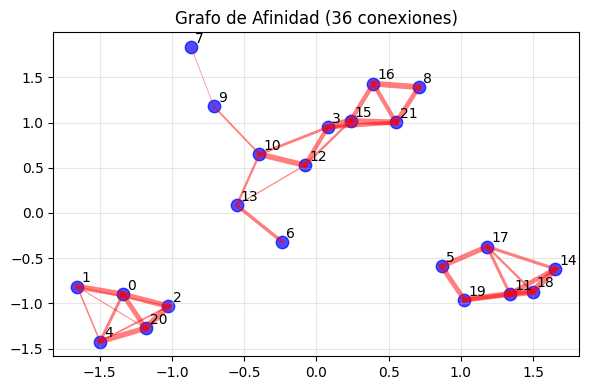

In [69]:
plt_grafo_afinidad(Dx, W)

 ## PASO 2: Calcular la Matriz Laplaciana
 Una vez obtenida la matriz de afinidad, el siguiente paso es calcular una matriz Laplaciana. Como se ha visto en la parte teórica, hay tres manera de hacerlo.

In [70]:
def laplaciano_no_normalizado(mAfinidad):
    D = np.diag(np.sum(mAfinidad, axis=1)) # p7 tu codigo aqui
    return D - mAfinidad

In [71]:
def matriz_Laplaciana_normalizada(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D = D**(-1)
    I = np.diag( np.ones(D.size) )
    D = np.diag(D)
    return I - D.dot(mAfinidad) # p8u codigo aqui

In [94]:
def matriz_Laplaciana_normalizada_simetrica(mAfinidad):
    D_sum = np.sum(mAfinidad, axis=1)
    # Handle cases where D_sum might be zero to avoid division by zero
    D_inv_sqrt = np.zeros_like(D_sum, dtype=float)
    non_zero_indices = D_sum != 0
    D_inv_sqrt[non_zero_indices] = D_sum[non_zero_indices]**(-0.5)

    D_diag_inv_sqrt = np.diag(D_inv_sqrt)
    I = np.eye(mAfinidad.shape[0])
    return I - D_diag_inv_sqrt.dot(mAfinidad).dot(D_diag_inv_sqrt)

 ## PASO 3: Análisis espectral

In [73]:
def calcula_valores_vectores_propios(mLaplaciana, K):
    # Calcular TODOS los vectores propios
    valores_pr, vectores_pr = linalg.eig(mLaplaciana)# p10 tu codigo aqui
    # Ordenar por valor propio ascendente
    orden = valores_pr.real.argsort()
    vectores_pr = vectores_pr.real[:, orden]
    # Tomar los primeros n_clusters vectores propios
    # Omitir el primer vector propio (valor ~0)
    Dx_trans = vectores_pr[:, orden] # p11 tu codigo aqui
    return Dx_trans

## PASO 4: Clustering en el Espacio de Vectores Propios

In [95]:
def agrupamiento_espectral(Dx, K, afinidad, laplaciana, **kwargs):
    mAfinidad = afinidad(Dx, **kwargs)
    mLaplaciana = laplaciana(mAfinidad) # p12 tu codigo aqui
    Dx_trans = calcula_valores_vectores_propios(mLaplaciana, K)[:, 1:K+1] # p13 tu codigo aqui
    # metodo de agrupamiento
    modelo = KMeans(n_clusters = K, random_state=0, n_init=10) # Added random_state and n_init for reproducibility and robustness
    modelo = modelo.fit(Dx_trans)
    Dyp = modelo.labels_ # p14 tu codigo aqui

    return [mAfinidad, Dyp]

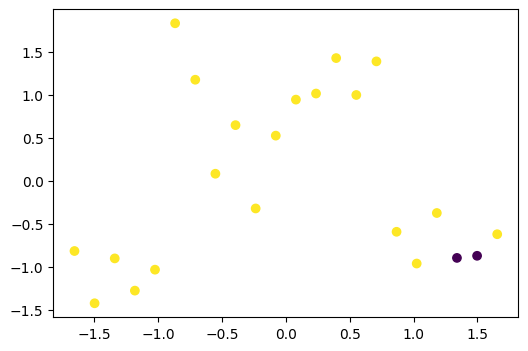

In [75]:
K = 2 # p15 tu codigo aqui
epsilon = 0.4
sigma = 0.017
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma= sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

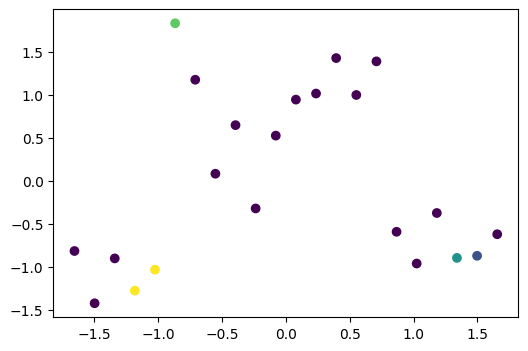

In [76]:
K = estimar_k_por_dimensionalidad(Dx) # p16 tu codigo aqui
epsilon= epsilon
sigma= sigma
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma= sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

# 🎯 **2:Pruebe el Algoritmo de Clustering Espectral**

✅ Dataset cargado desde URL GitHub


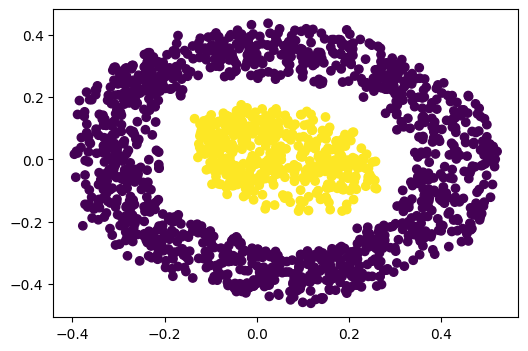

In [90]:
D =cargar_dataset("dataset_circulos_concentricos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

## Con el grafo ε-vecindad  y laplaciano no Normalizado

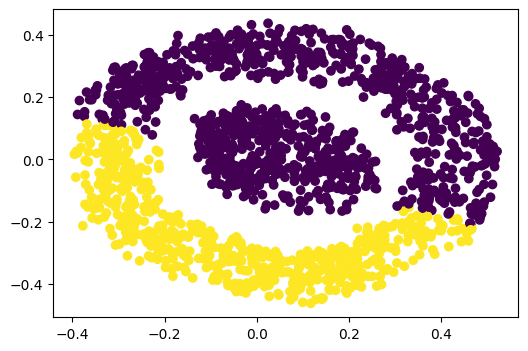

In [91]:
K = 2

epsilon = epsilon
sigma = sigma
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma=sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

## Con El grafo k-Vecinos

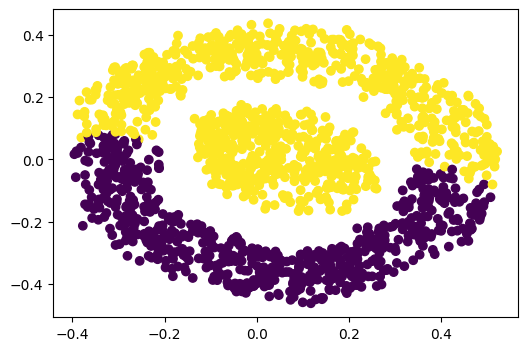

In [79]:
K = 2 # # p18 tu codigo aqui
knn = estimar_k_por_dimensionalidad(Dx)
sigma_global, _ = sigma_adaptativo_por_punto(Dx, k=knn)

mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_knn, matriz_Laplaciana_normalizada_simetrica, knn=knn, sigma=sigma_global, modo='interseccion')

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

## Cambiado de Laplaciano


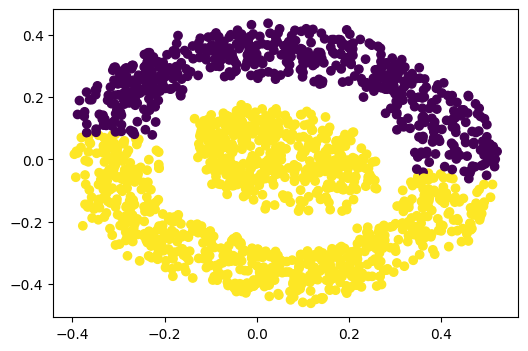

In [80]:
K = 2 # p19 tu codigo aqui
knn = estimar_k_por_dimensionalidad(Dx)
sigma, _ = sigma_adaptativo_por_punto(Dx, k=knn)
modo='mutuo' ## union, interseccion, mutuo
mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_knn, matriz_Laplaciana_normalizada, knn=knn, sigma= sigma, modo= modo)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

<hr>
Experimente con el dataset dos remolinos


In [81]:
D =cargar_dataset("dataset_dos_remolinos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


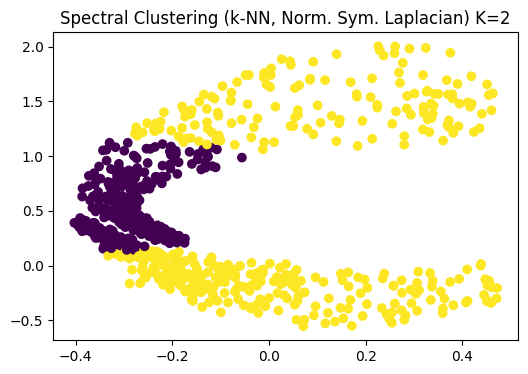

In [82]:
# 2. Configuración y ejecución
K = 2
knn = estimar_k_por_dimensionalidad(Dx)
sigma_global, _ = sigma_adaptativo_por_punto(Dx, k=knn)

mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_knn, matriz_Laplaciana_normalizada_simetrica, knn=knn, sigma=sigma_global, modo='interseccion')

# 3. Visualización
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp)
ax.set_title(f'Spectral Clustering (k-NN, Norm. Sym. Laplacian) K={K}')
plt.show()

Experimente con el dataset cuatro diferente medida

In [83]:
D =cargar_dataset("dataset_cuatro_diferente_medida.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


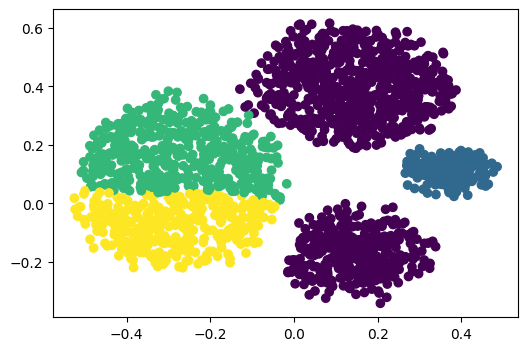

In [84]:
K = 4 # p21. Complete el codigo
knn = estimar_k_por_dimensionalidad(Dx)
sigma_global, _ = sigma_adaptativo_por_punto(Dx, k=knn)

mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_knn, matriz_Laplaciana_normalizada_simetrica, knn=knn, sigma=sigma_global, modo='interseccion')

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering espectral.

Están implementadas (parámetro affinity) las matrices de afinidad completa y KNN. Usa la matriz Laplaciana normalizada.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


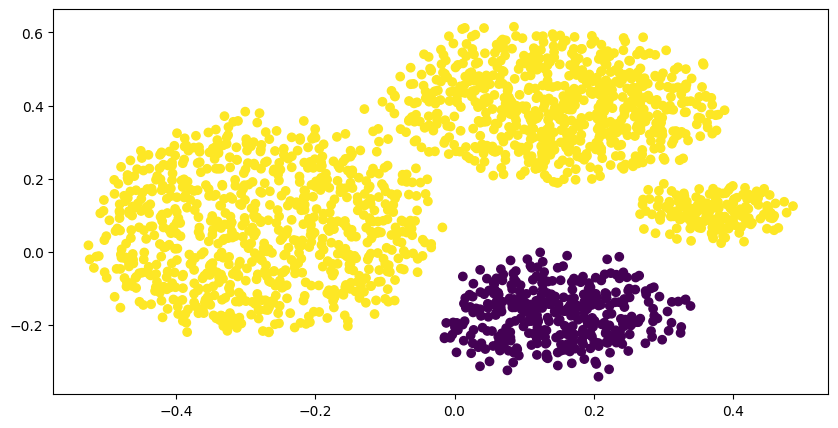

In [85]:
from sklearn.cluster import SpectralClustering
K = 2
knn = 5
clustering = SpectralClustering(n_clusters = K,
                                affinity = 'nearest_neighbors', n_neighbors = knn,
                                random_state = 0).fit(Dx)

fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)

Que metodo funciona mejor para los 5 Dataset y porque?


*   dataset_circulos_concentricos
*   dataset_cuatro_diferente_densidad
*   dataset_cuatro_separables_peque
*   dataset_cuatro_diferente_medida
*   dataset_inseparable



✅ Dataset cargado desde URL GitHub


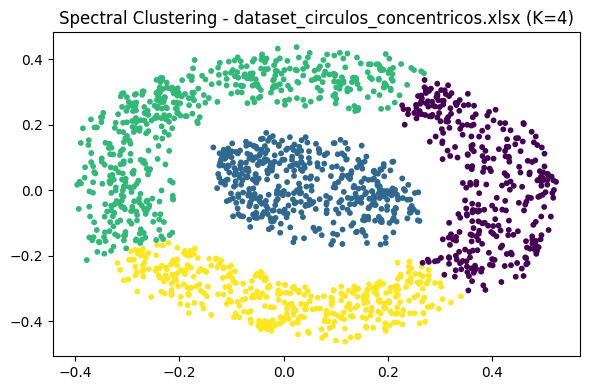

✅ Dataset cargado desde URL GitHub


/tmp/ipython-input-3285128511.py:14: RuntimeWarning: divide by zero encountered in log
  dim_estimada = 1 / (np.log(ratios).mean(axis=1).mean())


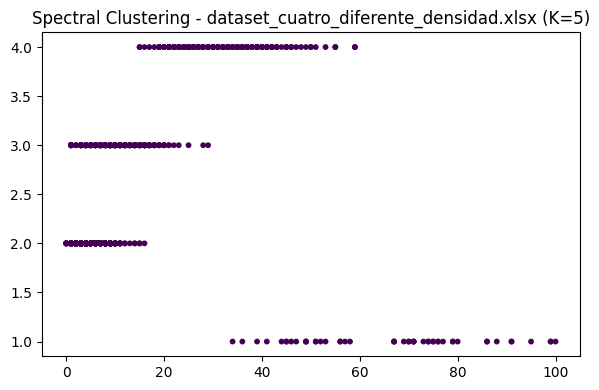

✅ Dataset cargado desde URL GitHub


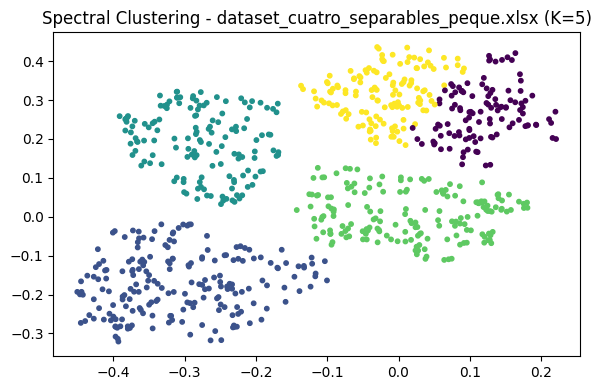

✅ Dataset cargado desde URL GitHub


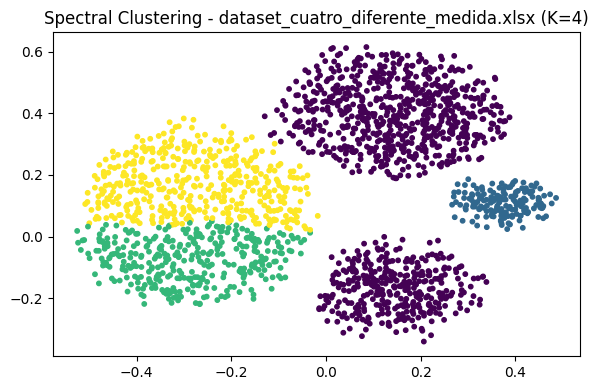

✅ Dataset cargado desde URL GitHub


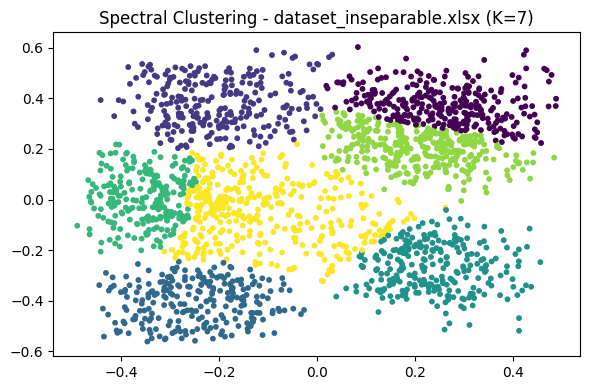

In [99]:
def comparar_metodos(nombre_archivo, K_real):
    # 1. Carga y limpieza de datos
    D = cargar_dataset(nombre_archivo)
    D = D[np.all(np.isfinite(D), axis=1)]
    Dx = D[:, 1:3]

    # 2. Ejecución de Spectral Clustering
    try:
        knn = estimar_k_por_dimensionalidad(Dx)
        sigma_g, _ = sigma_adaptativo_por_punto(Dx, k=knn)
        sigma_g = max(sigma_g, 1e-5)

        _, y_pred = agrupamiento_espectral(Dx, K_real, grafo_knn,
                        matriz_Laplaciana_normalizada_simetrica, knn=knn, sigma=sigma_g)
    except Exception as e:
        print(f"Error en Spectral para {nombre_archivo}: {e}")
        y_pred = np.zeros(Dx.shape[0])

    # 3. Graficado (Cambiado a 1 solo subplot)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(Dx[:, 0], Dx[:, 1], c=y_pred, s=10, cmap='viridis')

    ax.set_title(f"Spectral Clustering - {nombre_archivo} (K={K_real})")
    plt.tight_layout()
    plt.show()

# Ejecución (se mantiene igual)
for archivo, k in datasets:
    comparar_metodos(archivo, k)

El método Grafo $k$-Vecinos con Laplaciano Normalizado es considerablemente mejor para la mayoría de los datasets experimentales.
Mientras que el grafo $\epsilon$-vecindad es geométricamente intuitivo, el Laplaciano No Normalizado tiene un defecto matemático conocido: a menudo converge a soluciones triviales donde separa un solo punto del resto del grupo solo porque está ligeramente más alejado.

En cambio, al usar $k$-NN y normalización, se obliga al algoritmo a ignorar las diferencias de "brillo" o densidad de los puntos, permitiendo que se concentre exclusivamente en la geometría y conectividad, que es lo que realmente necesitas para resolver problemas como los círculos concéntricos o los remolinos.

# 🚀 ¡TALLER FINALIZADO!"